<a href="https://colab.research.google.com/github/enjoyPG/2023Gifted/blob/main/students/jwoo428/%ED%85%90%EC%B4%8811%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#직접만드는 번역기:어텐션 기계번역

###핵심용어
<br/>Seq2Seq모델링은 입력과 출력의 길이가 다른 데이터에서 사용
<br/>어텐션은 인코더의 마지막 은닉 상태뿐만 아니라 인코더의 모든 시점에서의 은닉 상태를 현재의 입력에 반영
<br/>토큰은 문자를 숫자로 나타내는 방법을 말함<SOS>와 <EOS>는 시작과끝을 나타냄
<br/>GRU는 셀 상태를 없애고 은닉 상태만을 이용해 과거와 현재의 정보를 추출함

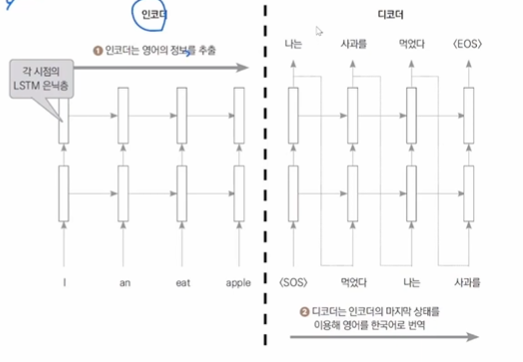

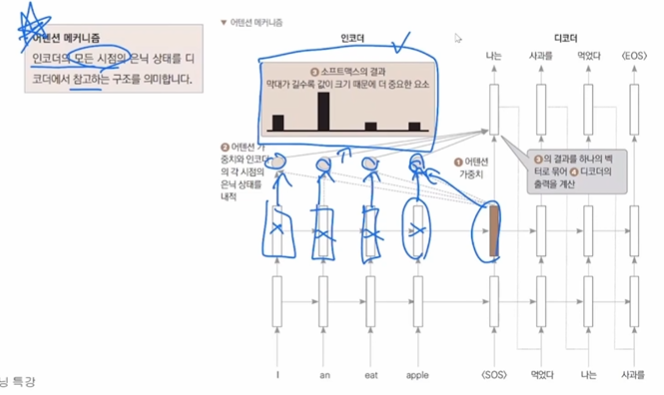

###GRU이해하기

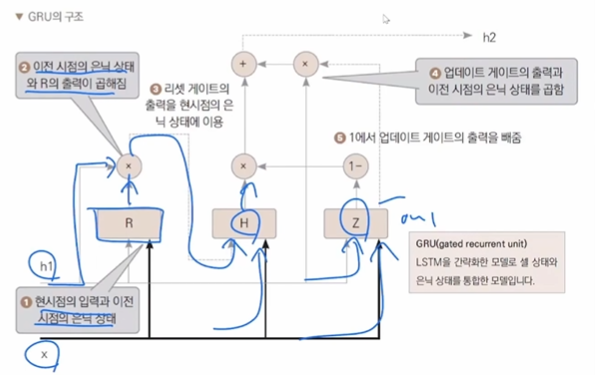

R은 망각게이트 같은 느낌(리셋게이트)
<BR/>Z는 업데이트 게이트(출력은 이전시점의 은닉상태와 곱해지고 1에서 업데이트 게이트의 값을 뺀 값을 현시점의 은닉 상태와 곱해줌)
<BR/>업데이트 게이트의 결과와 H의 출력을 곱해서 4번을 더하면 은닉상태를 구할 수 있음


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import string

l = []


# 한글 텍스트 파일을 읽기 위해 utf-8 인코딩으로 읽어옴
with open(
    "/content/drive/MyDrive/Colab Notebooks/data/CH11.txt",
    'r', encoding="utf-8") as f:
   lines = f.read().split("\n")
   for line in lines:
       # 특수 문자를 지우고 모든 글자를 소문자로 변경
       txt = "".join(v for v in line if v not in string.punctuation).lower()
       l.append(txt)

print(l[:5])

['go\t가', 'hi\t안녕', 'run\t뛰어', 'run\t뛰어', 'who\t누구']


###BOW함수

In [5]:
import numpy as np
import torch

from torch.utils.data.dataset import Dataset


def get_BOW(corpus):  # 문장들로부터 BOW를 만드는 함수
   BOW = {"<SOS>":0, "<EOS>":1}  #<SOS> 토큰과 <EOS> 토큰을 추가

   #문장 내 단어들을 이용해 BOW를 생성
   for line in corpus:
       for word in line.split():
           if word not in BOW.keys():
               BOW[word] = len(BOW.keys())

   return BOW

In [6]:
class Eng2Kor(Dataset):  # 학습에 이용할 데이터셋
   def __init__(
       self,
       pth2txt=\
       "/content/drive/MyDrive/Colab Notebooks/data/CH11.txt"):
       self.eng_corpus = []  # 영어 문장이 들어가는 변수
       self.kor_corpus = []  # 한글 문장이 들어가는 변수

       #텍스트 파일을 읽어서 영어 문장과 한글 문장을 저장
       with open(pth2txt, 'r', encoding="utf-8") as f:
           lines = f.read().split("\n")
           for line in lines:
               # 특수 문자와 대문자 제거
               txt = "".join(
                   v for v in line if v not in string.punctuation
                   ).lower()
               engtxt = txt.split("\t")[0]
               kortxt = txt.split("\t")[1]

               # 길이가 10 이하인 문장만을 사용
               if len(engtxt.split()) <= 10 and len(kortxt.split()) <= 10:
                   self.eng_corpus.append(engtxt)
                   self.kor_corpus.append(kortxt)

       self.engBOW = get_BOW(self.eng_corpus)  # 영어 BOW
       self.korBOW = get_BOW(self.kor_corpus)  # 한글 BOW
   # 문장을 단어별로 분리하고 마지막에 <EOS>를 추가
   def gen_seq(self, line):
       seq = line.split()
       seq.append("<EOS>")

       return seq
   def __len__(self): # ❶
       return len(self.eng_corpus)

   def __getitem__(self, i): # ❷
       # 문자열로 되어 있는 문장을 숫자 표현으로 변경
       data = np.array([
            self.engBOW[txt] for txt in self.gen_seq(self.eng_corpus[i])])

       label = np.array([
            self.korBOW[txt] for txt in self.gen_seq(self.kor_corpus[i])])

       return data, label

###데이터로더

In [7]:
def loader(dataset):  # 데이터셋의 문장을 한문장씩 불러오기 위한 함수
   for i in range(len(dataset)):
       data, label = dataset[i]

       # ❶ 데이터와 정답을 반환
       yield torch.tensor(data), torch.tensor(label)

###인코더정의

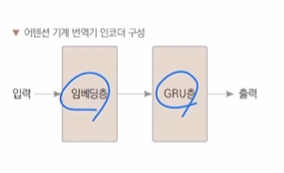

In [8]:
import torch.nn as nn


class Encoder(nn.Module):
   def __init__(self, input_size, hidden_size):
       super(Encoder, self).__init__()

       self.embedding = nn.Embedding(input_size, hidden_size)
       self.gru = nn.GRU(hidden_size, hidden_size)

   def forward(self, x, h):
       # ❶ 배치차원과 시계열 차원 추가
       x = self.embedding(x).view(1, 1, -1)
       output, hidden = self.gru(x, h)
       return output, hidden

###디코더정의

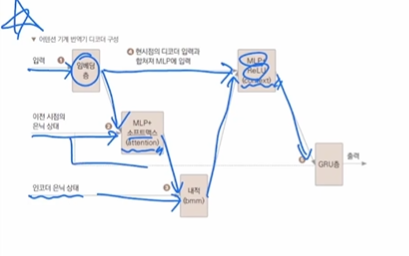

In [9]:
 class Decoder(nn.Module):
   def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=11):
       super(Decoder, self).__init__()

       # 임베딩층 정의
       self.embedding = nn.Embedding(output_size, hidden_size)

       # 어텐션 가중치를 계산하기 위한 MLP층
       self.attention = nn.Linear(hidden_size * 2, max_length)

       #특징 추출을 위한 MLP층
       self.context = nn.Linear(hidden_size * 2, hidden_size)

       # 과적합을 피하기 위한 드롭아웃 층
       self.dropout = nn.Dropout(dropout_p)

       # GRU층
       self.gru = nn.GRU(hidden_size, hidden_size)

       # 단어 분류를 위한 MLP층
       self.out = nn.Linear(hidden_size, output_size)

       # 활성화 함수
       self.relu = nn.ReLU()
       self.softmax = nn.LogSoftmax(dim=1)

   def forward(self, x, h, encoder_outputs):
       # 입력을 밀집 표현으로
       x = self.embedding(x).view(1, 1, -1)
       x = self.dropout(x)

       # 어텐션 가중치 계산
       attn_weights = self.softmax(
           self.attention(torch.cat((x[0], h[0]), -1)))

       # 어텐션 가중치와 인코더의 출력을 내적
       attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

       # 인코더 각 시점의 중요도와 민집표현을 합쳐
       # MLP층으로 특징 추출
       output = torch.cat((x[0], attn_applied[0]), 1)
       output = self.context(output).unsqueeze(0)
       output = self.relu(output)

       # GRU층으로 입력
       output, hidden = self.gru(output, h)

       # 예측된 단어 출력
       output = self.out(output[0])

       return output

In [10]:
import random
import tqdm

from torch.optim.adam import Adam


# 학습에 사용할 프로세서 정의
device = "cuda" if torch.cuda.is_available() else "cpu"
# 학습에 사용할 데이터셋 정의
dataset = Eng2Kor()


# 인코더 디코더 정의
encoder = Encoder(input_size=len(dataset.engBOW), hidden_size=64).to(device)
decoder = Decoder(64, len(dataset.korBOW), dropout_p=0.1).to(device)
# 인코더 디코더 학습을 위한 최적화 정의
encoder_optimizer = Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = Adam(decoder.parameters(), lr=0.0001)

###학습루프 정의

In [13]:
for epoch in range(3):
   iterator = tqdm.tqdm(loader(dataset), total=len(dataset))
   total_loss = 0

   for data, label in iterator:
       data = torch.tensor(data, dtype=torch.long).to(device)
       label = torch.tensor(label, dtype=torch.long).to(device)

       # 인코더의 초기 은닉 상태
       encoder_hidden = torch.zeros(1, 1, 64).to(device)
       # 인코더의 모든 시점의 출력을 저장하는 변수
       encoder_outputs = torch.zeros(11, 64).to(device)

       encoder_optimizer.zero_grad()
       decoder_optimizer.zero_grad()

       loss = 0
       for ei in range(len(data)):
           # 한 단어씩 인코더에 넣어줌
           encoder_output, encoder_hidden = encoder(
               data[ei], encoder_hidden)
           # 인코더의 은닉 상태를 저장
           encoder_outputs[ei] = encoder_output[0, 0]

       decoder_input = torch.tensor([[0]]).to(device)

       # 인코더의 마지막 은닉 상태를 디코더의 초기 은닉 상태로 저장
       decoder_hidden = encoder_hidden
       use_teacher_forcing = True if random.random() < 0.5 else False  # ❶

       if use_teacher_forcing:
           for di in range(len(label)):
               decoder_output = decoder(
                   decoder_input, decoder_hidden, encoder_outputs)

               # 직접적으로 정답을 다음 시점의 입력으로 넣어줌
               target = torch.tensor(label[di], dtype=torch.long).to(device)
               target = torch.unsqueeze(target, dim=0).to(device)
               loss += nn.CrossEntropyLoss()(decoder_output, target)
               decoder_input = target
       else:
           for di in range(len(label)):
               decoder_output = decoder(
                   decoder_input, decoder_hidden, encoder_outputs)

               #  가장 높은 확률을 갖는 단어의 인덱스가 topi
               topv, topi = decoder_output.topk(1)
               decoder_input = topi.squeeze().detach()

               # 디코더의 예측값을 다음 시점의 입력으로 넣어줌
               target = torch.tensor(label[di], dtype=torch.long).to(device)
               target = torch.unsqueeze(target, dim=0).to(device)
               loss += nn.CrossEntropyLoss()(decoder_output, target)

               if decoder_input.item() == 1:  # <EOS> 토큰을 만나면 중지
                   break
       # 전체 손실 계산
       total_loss += loss.item()/len(dataset)
       iterator.set_description(f"epoch:{epoch+1} loss:{total_loss}")
       loss.backward()

       encoder_optimizer.step()
       decoder_optimizer.step()

torch.save(encoder.state_dict(), "attn_enc.pth")
torch.save(decoder.state_dict(), "attn_dec.pth")

  0%|          | 0/3592 [00:00<?, ?it/s]<ipython-input-13-a2677f40b6fc>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.long).to(device)
<ipython-input-13-a2677f40b6fc>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long).to(device)
<ipython-input-13-a2677f40b6fc>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label[di], dtype=torch.long).to(device)
epoch:1 loss:0.006573939376525199:   0%|          | 0/3592 [00:00<?, ?it/s]<ipython-in

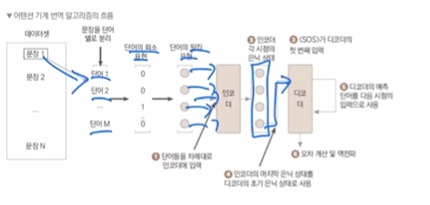

In [14]:
# 인코더 가중치 불러오기
encoder.load_state_dict(torch.load("attn_enc.pth", map_location=device))
# 디코더 가중치 불러오기
decoder.load_state_dict(torch.load("attn_dec.pth", map_location=device))


# 불러올 영어 문장을 랜덤하게 지정
idx = random.randint(0, len(dataset))
# 테스트에 사용할 문장
input_sentence = dataset.eng_corpus[idx]
# 신경망이 번역한 문장
pred_sentence = ""

data, label = dataset[idx]
data = torch.tensor(data, dtype=torch.long).to(device)
label = torch.tensor(label, dtype=torch.long).to(device)

# 인코더의 초기 은닉 상태 정의
encoder_hidden = torch.zeros(1, 1, 64).to(device)
# 인코더 출력을 담기위한 변수
encoder_outputs = torch.zeros(11, 64).to(device)

###인코더 동작

In [15]:
for ei in range(len(data)):
   #한 단어씩 인코더에 넣어줌
   encoder_output, encoder_hidden = encoder(
       data[ei], encoder_hidden)

   #인코더의 출력을 저장
   encoder_outputs[ei] = encoder_output[0, 0]


#디코더의 초기 입력
# 0은 <SOS>토큰
decoder_input = torch.tensor([[0]]).to(device)

#인코더의 마지막 은닉 상태를 디코더의 초기 은닉 상태로
decoder_hidden = encoder_hidden

###디코더 동작

In [16]:
for di in range(11):
    #가장 높은 확률을 갖는 단어의 요소를 구함
   decoder_output = decoder(
                       decoder_input, decoder_hidden, encoder_outputs)
   topv, topi = decoder_output.topk(1)
   decoder_input = topi.squeeze().detach()

   #<EOS> 토큰을 만나면 중지
   if decoder_input.item() == 1:
       break

   #가장 높은 단어를 문자열에 추가
   pred_sentence += list(dataset.korBOW.keys())[decoder_input] + " "

print(input_sentence)  # 영어 문장
print(pred_sentence)  # 한글 문장

i dont care what you thought
난 난 난 난 난 난 난 난 난 난 난 


요거는 에포크 땜시...ㅎㅎ